In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from matplotlib.transforms import Affine2D
from matplotlib.patches import ConnectionPatch

from PIL import Image

import skimage.io
import skimage.color
import skimage.exposure
from skimage.color import rgb2gray
from skimage.transform import rotate

import glob

# Data loader

In [121]:
def show_imgs(imgs, size=(10,6), title=""):
    fig, axes = plt.subplots(1,len(imgs), figsize=size)
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i])

    fig.suptitle(title, fontsize=12)
    plt.show()

In [122]:
def data_loader(path: str, appear=False, show_size=(12,6), title = ""):
    image_paths = sorted(glob.glob(path))
    imgs = []

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        imgs.append(img)
    
    if appear == True:
        show_imgs(imgs, show_size, title)

    return imgs

# Data cleaning

In [123]:
def nomalize_images(imgs, appear=False, title=""):

    nomal_imgs = []
    for img in imgs:
        img_norm = img / np.max(img)
        img_norm_uint8 = (img_norm * 255).astype(np.uint8)

        nomal_imgs.append(img_norm_uint8)

    if appear == True:
        show_imgs(nomal_imgs, title=title)

    return nomal_imgs

In [124]:
def to_gray_images(imgs, appear=False, title=""):
    
    gray_imgs = []
    for img in imgs:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_imgs.append(gray_img)

    if appear == True:
        show_imgs(gray_imgs, title=title)

    return gray_imgs

# Feature detector

In [125]:
def harris_coner_detector(imgs: list, blockSize: int, ksize: int, k_harris_parameter=0.04, threshold=0.01, appear=False):

    keypoints = []
    for img in imgs:
        conner = cv2.cornerHarris(img, blockSize, ksize, k_harris_parameter)
        conner = cv2.dilate(conner, None)
        
        points = np.argwhere(conner > threshold * conner.max())
        keypoint = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in points]

        keypoints.append(keypoint)

    if appear == True:
        plot_keypoints(imgs, keypoints)

    return keypoints

In [126]:
def plot_keypoints(imgs, keypoints):

    _, axes = plt.subplots(1,len(imgs), figsize=(10,6))
    for i in range(len(imgs)):
        points = np.array([list(keypoint.pt) for keypoint in keypoints[i]])

        axes[i].imshow(imgs[i])
        axes[i].scatter(points[:,0], points[:,1], marker='x', color='r')

    plt.show()

# Image matching

In [127]:
def matching_images(gray_imgs, keypoints, num_top_matches=50, appear=False):
    sift = cv2.SIFT_create()
    
    matched_points = []
    
    for i in range(len(gray_imgs)-1):
        # src image
        gray_src = gray_imgs[i]
        src_keypoints = keypoints[i]

        for j in range(i+1,len(gray_imgs)):
            # des image
            gray_des = gray_imgs[j]
            des_keypoints = keypoints[j]

            # Detect descriptors using SIFT
            src_keypoints, src_descriptors = sift.compute(gray_src, src_keypoints)
            des_keypoints, des_descriptors = sift.compute(gray_des, des_keypoints)
            
            # Match descriptors using FLANN matcher
            matcher = cv2.FlannBasedMatcher()
            matches = matcher.match(src_descriptors, des_descriptors)

            # Sort matches by distance
            matches = sorted(matches, key=lambda x:x.distance)

            # Select top matches
            matches = matches[:num_top_matches]

            # Extract matched keypoints
            src_points = np.float32([src_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            des_points = np.float32([des_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            
            matched_points.append([src_points, des_points, i, j])

            if appear == True:
                plot_matches(gray_src, gray_des, src_points, des_points)

    # Return value: [[src matched points, des matched point, index of src image, index of des image], ...]
    return matched_points

In [128]:
# use this function to visualize the matches
def plot_matches(src_img, des_img, src_points, des_points):
    fig, axes = plt.subplots(1,2,figsize=(10,6))

    # draw images
    axes[0].imshow(src_img)
    axes[1].imshow(des_img)

    # draw matches
    for src_point, des_point in zip(src_points, des_points):
        kp1, kp2 = src_point[0], des_point[0]

        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color='r')
        fig.add_artist(con)
        axes[0].plot(*kp1, color='r', marker='x')
        axes[1].plot(*kp2, color='r', marker='x')
    
    plt.show()

# Global alignment

# Blending and Compositing

In [129]:
def warpTwoImages(img_src, img_des, H, appear=False):
    # Warp the source image to align with the destination image 
    h1,w1 = img_src.shape[:2]
    h2,w2 = img_des.shape[:2]

    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    wrap_src_img = cv2.warpPerspective(img_src, Ht.dot(H), (xmax-xmin, ymax-ymin))

    # Combine the two images into a panorama
    wrap_src_img[t[1]:h1+t[1],t[0]:w1+t[0]] = img_des
    
    if appear == True:
        plt.imshow(wrap_src_img)
        plt.title('Panorama result')
        plt.show()

    return wrap_src_img
    

## Main function

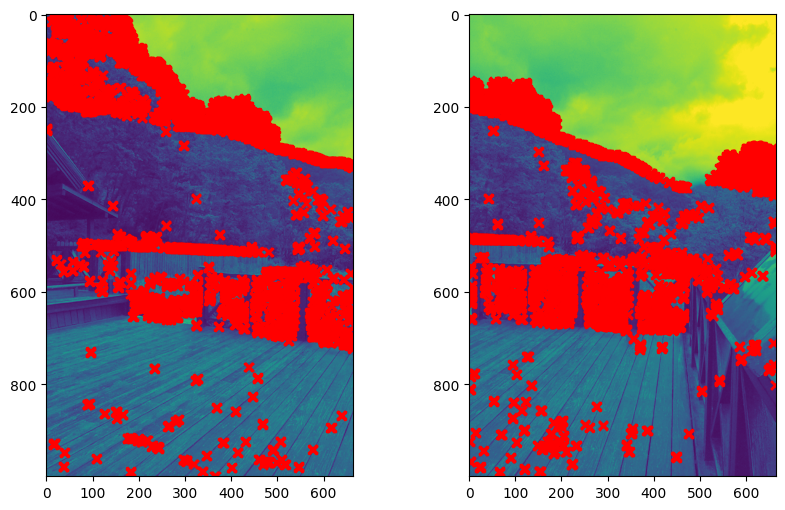

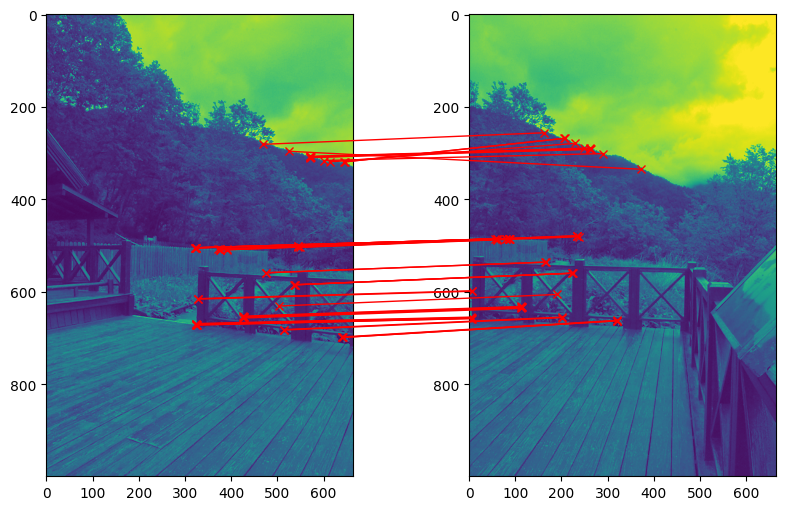

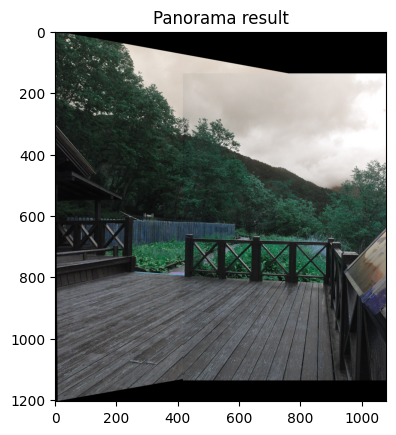

error: OpenCV(4.7.0) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [130]:
def stitching_images_harris_test():
    # Load images. CV2 reads in BGR format
    imgs = data_loader('data/xue-mountain/*.jpg')
    # test with the first two images
    imgs = [img_src, img_des] = imgs[:2]

    # Normalize values, change data type
    imgs_norm_uint8 = nomalize_images(imgs, title="Nomalized images")
    
    # Grayscale images
    gray_imgs = [gray_src, gray_des] = to_gray_images(imgs_norm_uint8) 
    
    # Harris conner detector
    keypoints = harris_coner_detector(gray_imgs,
                                    blockSize=2, 
                                    ksize=3,
                                    k_harris_parameter=0.04, 
                                    threshold=0.01,
                                    appear=True)

    # Matching images, because there are only two images for testing => only one patched points
    matched_points = [[src_points, des_points, _, _]] = matching_images(gray_imgs, keypoints,
                                                                        num_top_matches=50,
                                                                        appear=True)

    # Compute homography matrix using RANSAC
    H, mask = cv2.findHomography(src_points, des_points, cv2.RANSAC, 10.0)

    # warp and combine two image
    panorama = warpTwoImages(img_src, img_des, H, appear=True)
    
    # Blend the two images in the panorama
    alpha = 0.5
    panorama = cv2.addWeighted(panorama[:, :panorama.shape[1], :], alpha, panorama[:, panorama.shape[1]:, :], 1 - alpha, 0)

    # Fix the color channels of the blended image
    panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

    return panorama

HARRIS_IMAGE_RESULT = stitching_images_harris_test()
plt.imshow(HARRIS_IMAGE_RESULT)
plt.title('Panorama result')
plt.show()

# Output

In [ ]:
### General code structure

def stitching_images(img_src: np.array, img_des: np.array):
    gd_src = rgb2gray(img_src)
    gd_des = rgb2gray(img_des)

    ### TODO: Harris conner detecting and the patches - areas around conners

    ### TODO: SIFT computing the feature description by gradient of each patch

    ### TODO: Compute distance matrix based on SIFT of each patch

    ### TODO: Match each patch with from distance matrix above

    ### TODO: Run RANSAC to remove the outline pair of patch

    ### TODO: Composite two images into one

    ### TODO: Normalize the images (e.g. have same brightness levels)

    return [combined_image, Harris, num_inliers, residual]